In [ ]:
"""
Author: Manisha Saini
Team Name: AgroGenius
Team Members: Manisha Saini, Radhika Bhati, Deepanshu Aggarwal, Sayantan, Sejal Kumari
Leaderboard Rank: 

"""

In [ ]:
# Core Libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, UnidentifiedImageError # Pillow for image manipulation

# PyTorch Libraries
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torchvision import transforms
import torchvision.models as models # For pre-trained models

# Scikit-learn for Preprocessing
from sklearn.preprocessing import StandardScaler

# Utilities
from tqdm.notebook import tqdm # For progress bars

In [ ]:
# --- Input/Output Paths ---
KAGGLE_INPUT_DIR = '/kaggle/input/soil-classification-part-2/soil_competition-2025'
TRAIN_IMAGE_DIR = os.path.join(KAGGLE_INPUT_DIR, 'train')
TEST_IMAGE_DIR = os.path.join(KAGGLE_INPUT_DIR, 'test')
TRAIN_LABELS_CSV = os.path.join(KAGGLE_INPUT_DIR, 'train_labels.csv')
TEST_IDS_CSV = os.path.join(KAGGLE_INPUT_DIR, 'test_ids.csv')

# Output submission filename as per competition requirements
FINAL_SUBMISSION_FILENAME = "Submission_challenge_2.csv"
OUTPUT_DIR = "/kaggle/working/" # Standard Kaggle output directory

# --- Model & Training Hyperparameters ---
# Image Processing
IMG_SIZE = 224 

# Feature Extraction (using ResNet50)
FEATURE_EXTRACTION_BATCH_SIZE = 64

# Autoencoder Architecture & Training 
# Input dimension for AE will be ResNet50's feature output size (2048)
AE_BOTTLENECK_DIM = 64
AE_ENCODING_DIM1 = 1024  # Hidden layer 1 size
AE_ENCODING_DIM2 = 256   # Hidden layer 2 size
AE_EPOCHS = 100          # Number of training epochs for the AE
AE_LR = 0.001            # Learning rate for AE training
AE_DROPOUT = 0.3         # Dropout rate for AE layers
AE_TRAIN_BATCH_SIZE = 32 # Batch size for AE training

# Thresholding for Anomaly Detection
THRESHOLD_PERCENTILE_OF_TRAIN_ERRORS = 96 

# Device Configuration
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")
print(f"Autoencoder Parameters: Bottleneck={AE_BOTTLENECK_DIM}, Dim1={AE_ENCODING_DIM1}, Dim2={AE_ENCODING_DIM2}")
print(f"AE Training: Epochs={AE_EPOCHS}, LR={AE_LR}, Dropout={AE_DROPOUT}, BatchSize={AE_TRAIN_BATCH_SIZE}")
print(f"Thresholding: Using {THRESHOLD_PERCENTILE_OF_TRAIN_ERRORS}th percentile of training reconstruction errors.")

Using device: cuda
Autoencoder Parameters: Bottleneck=64, Dim1=1024, Dim2=256
AE Training: Epochs=100, LR=0.001, Dropout=0.3, BatchSize=32
Thresholding: Using 96th percentile of training reconstruction errors.


In [ ]:
class ImagePathDataset(Dataset):
    """
    Custom PyTorch Dataset to load images from a list of (image_id, image_path) tuples.
    It's designed to be robust to image loading errors, returning a zero tensor
    if an image cannot be opened or processed.
    """
    def __init__(self, image_paths_with_ids, transform=None):
        """
        Args:
            image_paths_with_ids (list): A list of tuples, where each tuple is (image_id, path_to_image).
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.image_paths_with_ids = image_paths_with_ids
        self.transform = transform

    def __len__(self):
        """Returns the total number of samples."""
        return len(self.image_paths_with_ids)

    def __getitem__(self, idx):
        """
        Generates one sample of data.
        Args:
            idx (int): Index of the sample.
        Returns:
            tuple: (image, image_id) where image is a tensor and image_id is a string.
                   Returns a zero tensor for the image if loading fails.
        """
        img_id, img_path = self.image_paths_with_ids[idx]
        try:
            # Open image, convert to RGB (handles grayscale, RGBA, etc.)
            image = Image.open(img_path).convert("RGB")
        except UnidentifiedImageError:
            # This error occurs if PIL cannot identify the image file format.
            return torch.zeros((3, IMG_SIZE, IMG_SIZE)), img_id 
        except Exception as e:
            # Catch other potential errors during image opening.
            return torch.zeros((3, IMG_SIZE, IMG_SIZE)), img_id 

        # Apply transformations if any (e.g., resize, to tensor, normalize)
        if self.transform:
            image = self.transform(image)
            
        return image, img_id

In [4]:
def load_feature_extractor(device):
    """
    Loads a pre-trained ResNet50 model and modifies it for feature extraction.
    The final fully connected layer (classifier) is replaced with an Identity layer
    to output the features from the penultimate layer.
    Args:
        device (torch.device): The device (CPU or CUDA) to load the model onto.
    Returns:
        torch.nn.Module: The loaded and modified ResNet50 model.
    """
    print("Loading pre-trained ResNet50 model for feature extraction...")
    # Load ResNet50 with weights pre-trained on ImageNet1K (Version 1)
    model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
    
    # Replace the final classification layer (fc) with an Identity layer.
    # This makes the model output the 2048-dimensional feature vector
    # from the layer before the original classifier.
    model.fc = nn.Identity()
    
    model.to(device)  # Move the model to the specified device
    model.eval()      # Set the model to evaluation mode (disables dropout, batchnorm updates)
    print("ResNet50 model loaded and configured for feature extraction.")
    return model

In [5]:
def extract_features_from_images(image_data_list, feature_model, image_transform, device, batch_size):
    """
    Extracts deep features from a list of images using the provided feature_model.
    Args:
        image_data_list (list): List of (image_id, image_path) tuples.
        feature_model (torch.nn.Module): The pre-trained model for feature extraction.
        image_transform (callable): Transformations to apply to each image.
        device (torch.device): The device to perform computation on.
        batch_size (int): Number of images to process in one batch.
    Returns:
        tuple: (numpy.ndarray of features, list of image_ids in order of features)
    """
    # Create dataset and dataloader
    dataset = ImagePathDataset(image_data_list, transform=image_transform)
    
    # num_workers for DataLoader: 0 for main process, >0 for multiprocessing.
    # Using 2 for CUDA if available, 0 for CPU for wider compatibility.
    num_workers = 2 if device.type == 'cuda' else 0
    
    data_loader = DataLoader(dataset, 
                             batch_size=batch_size, 
                             shuffle=False, # Important: preserve order for matching features to IDs
                             num_workers=num_workers,
                             pin_memory=(True if device.type == 'cuda' else False)) # Speeds up CPU-GPU transfer
    
    all_extracted_features = []
    all_image_ids_ordered = []
    
    # Disable gradient calculations during feature extraction for speed and memory efficiency
    with torch.no_grad():
        # Iterate over data using tqdm for a progress bar
        for images_batch, ids_batch in tqdm(data_loader, desc="Extracting Features", leave=False):
            images_batch = images_batch.to(device) # Move image batch to device
            features_batch = feature_model(images_batch) # Get features
            
            # Append features (moved to CPU, converted to NumPy) and IDs
            all_extracted_features.append(features_batch.cpu().numpy())
            all_image_ids_ordered.extend(list(ids_batch))
            
    # Concatenate all feature batches into a single NumPy array
    if not all_extracted_features: # Handle empty list case
        return np.array([]), []
        
    return np.vstack(all_extracted_features), all_image_ids_ordered

In [6]:
class FeatureAutoencoder(nn.Module):
    """
    A simple Autoencoder model for learning compressed representations of input features.
    It consists of an encoder that maps input features to a lower-dimensional bottleneck,
    and a decoder that reconstructs the original features from the bottleneck.
    """
    def __init__(self, input_dim, encoding_dim1, encoding_dim2, bottleneck_dim, dropout_rate):
        """
        Args:
            input_dim (int): Dimensionality of the input features.
            encoding_dim1 (int): Size of the first hidden layer in encoder/decoder.
            encoding_dim2 (int): Size of the second hidden layer in encoder/decoder.
            bottleneck_dim (int): Size of the bottleneck (compressed representation).
            dropout_rate (float): Dropout probability for regularization.
        """
        super(FeatureAutoencoder, self).__init__()
        
        # Encoder part
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, encoding_dim1),
            nn.ReLU(True),
            nn.Dropout(dropout_rate),
            nn.Linear(encoding_dim1, encoding_dim2),
            nn.ReLU(True),
            nn.Dropout(dropout_rate),
            nn.Linear(encoding_dim2, bottleneck_dim),
            nn.ReLU(True) # ReLU at bottleneck can be common for non-negativity if desired,
                          # but can also be omitted or use another activation.
        )
        
        # Decoder part (mirrors the encoder)
        self.decoder = nn.Sequential(
            nn.Linear(bottleneck_dim, encoding_dim2),
            nn.ReLU(True),
            nn.Dropout(dropout_rate),
            nn.Linear(encoding_dim2, encoding_dim1),
            nn.ReLU(True),
            nn.Dropout(dropout_rate),
            nn.Linear(encoding_dim1, input_dim) # No activation for final output to match scaled features
        )
        
    def forward(self, x):
        """Defines the forward pass of the autoencoder."""
        x_encoded = self.encoder(x)
        x_reconstructed = self.decoder(x_encoded)
        return x_reconstructed

In [7]:
def train_autoencoder_model(ae_model, scaled_features_train, device, epochs, learning_rate, batch_size_ae):
    """
    Trains the provided autoencoder model on the scaled training features.
    Args:
        ae_model (torch.nn.Module): The autoencoder model instance.
        scaled_features_train (numpy.ndarray): Scaled features of the training data.
        device (torch.device): Device to train on.
        epochs (int): Number of training epochs.
        learning_rate (float): Learning rate for the optimizer.
        batch_size_ae (int): Batch size for AE training.
    Returns:
        torch.nn.Module: The trained autoencoder model.
    """
    print(f"Starting Autoencoder training: {epochs} epochs, LR={learning_rate}, BatchSize={batch_size_ae}")
    ae_model.to(device) # Move model to device
    
    # Loss function: Mean Squared Error is common for autoencoders
    criterion = nn.MSELoss()
    # Optimizer: AdamW is often preferred for its weight decay handling
    optimizer = optim.AdamW(ae_model.parameters(), lr=learning_rate, weight_decay=1e-5)
    
    # Create PyTorch dataset and dataloader for training features
    feature_dataset = torch.utils.data.TensorDataset(torch.from_numpy(scaled_features_train).float())
    num_workers_ae = 2 if device.type == 'cuda' else 0
    feature_loader = torch.utils.data.DataLoader(feature_dataset, 
                                                 batch_size=batch_size_ae, 
                                                 shuffle=True, # Shuffle training data each epoch
                                                 num_workers=num_workers_ae,
                                                 pin_memory=(True if device.type == 'cuda' else False))
    
    # Training loop
    for epoch in tqdm(range(epochs), desc="Training Autoencoder", leave=False):
        ae_model.train() # Set model to training mode
        # epoch_loss_sum = 0.0 # To track average loss per epoch (optional for final script)
        for data_batch in feature_loader:
            batch_features = data_batch[0].to(device) # Get batch and move to device
            
            optimizer.zero_grad()         # Clear previous gradients
            outputs = ae_model(batch_features) # Forward pass: get reconstructions
            loss = criterion(outputs, batch_features) # Calculate reconstruction loss
            loss.backward()               # Backward pass: compute gradients
            optimizer.step()              # Update model weights
            # epoch_loss_sum += loss.item() * batch_features.size(0)
            
        # avg_epoch_loss = epoch_loss_sum / len(feature_dataset)
        # Print progress (less frequently for cleaner log)
        # if (epoch + 1) % (epochs // 5 if epochs >= 5 else 1) == 0 or epoch == epochs - 1:
            # print(f'  Epoch [{epoch+1}/{epochs}], Avg Reconstruction Loss: {avg_epoch_loss:.6f}')
            
    print("Autoencoder training finished.")
    return ae_model

In [8]:
def calculate_reconstruction_errors(ae_model, scaled_features, device, batch_size_ae):
    """
    Calculates reconstruction errors for given features using a trained autoencoder.
    Args:
        ae_model (torch.nn.Module): The trained autoencoder model.
        scaled_features (numpy.ndarray): Scaled features to reconstruct.
        device (torch.device): Device for computation.
        batch_size_ae (int): Batch size for processing.
    Returns:
        numpy.ndarray: Array of reconstruction errors (MSE per sample).
    """
    ae_model.eval() # Set model to evaluation mode
    all_errors = []
    
    feature_dataset = torch.utils.data.TensorDataset(torch.from_numpy(scaled_features).float())
    num_workers_ae = 2 if device.type == 'cuda' else 0
    feature_loader = torch.utils.data.DataLoader(feature_dataset, 
                                                 batch_size=batch_size_ae, 
                                                 shuffle=False, # No shuffling for error calculation
                                                 num_workers=num_workers_ae,
                                                 pin_memory=(True if device.type == 'cuda' else False))
    
    with torch.no_grad(): # Disable gradients
        for data_batch in tqdm(feature_loader, desc="Calculating Errors", leave=False):
            batch_features = data_batch[0].to(device)
            reconstructed_features = ae_model(batch_features)
            
            # Calculate Mean Squared Error for each sample in the batch
            # (feature_vector - reconstructed_feature_vector)^2, then mean across feature dimension
            batch_mse_errors = torch.mean((batch_features - reconstructed_features)**2, dim=1)
            all_errors.extend(batch_mse_errors.cpu().numpy())
            
    return np.array(all_errors)

In [ ]:
# --- Define Image Transformations ---
imagenet_normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                          std=[0.229, 0.224, 0.225])
feature_extraction_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    imagenet_normalize
])
# --- End of moved definition ---


# --- 1. Load Data Paths ---
print("Step 1: Loading data paths...")
train_labels_df = pd.read_csv(TRAIN_LABELS_CSV)
train_image_data_tuples = [(fname, os.path.join(TRAIN_IMAGE_DIR, fname)) for fname in train_labels_df['image_id'].tolist()]
print(f"  Found {len(train_image_data_tuples)} soil images for training.")

test_ids_df = pd.read_csv(TEST_IDS_CSV) # This DataFrame defines the submission order and IDs
test_image_data_tuples = [(fname, os.path.join(TEST_IMAGE_DIR, fname)) for fname in test_ids_df['image_id'].tolist()]
print(f"  Found {len(test_image_data_tuples)} test images for prediction.")

# --- 2. Load Feature Extractor Model ---
print("\nStep 2: Loading feature extractor model...")
feature_extractor = load_feature_extractor(DEVICE) 

# --- 3. Extract Features ---
print("\nStep 3: Extracting features from images...")
# Training features
print("  Extracting features from training (soil) images...")
train_features_raw, _ = extract_features_from_images( 
    train_image_data_tuples, feature_extractor, feature_extraction_transforms, DEVICE, FEATURE_EXTRACTION_BATCH_SIZE
)
print(f"  Shape of raw training features: {train_features_raw.shape}")

# Test features
print("  Extracting features from test images...")
test_features_raw, test_image_ids_ordered = extract_features_from_images(
    test_image_data_tuples, feature_extractor, feature_extraction_transforms, DEVICE, FEATURE_EXTRACTION_BATCH_SIZE
)
print(f"  Shape of raw test features: {test_features_raw.shape}")

# --- 4. Scale Features ---
print("\nStep 4: Scaling features using StandardScaler...")
scaler = StandardScaler()
# Fit scaler on training features and transform both train and test features
train_features_scaled = scaler.fit_transform(train_features_raw)
test_features_scaled = scaler.transform(test_features_raw)
print("  Features scaled.")

# --- 5. Initialize and Train Autoencoder ---
# Using the pre-defined best parameters for the AE
print("\nStep 5: Initializing and training the Autoencoder...")
# Ensure input_dim matches the extracted feature dimension (e.g., 2048 for ResNet50)
autoencoder_model = FeatureAutoencoder(input_dim=train_features_scaled.shape[1], 
                                     encoding_dim1=AE_ENCODING_DIM1,
                                     encoding_dim2=AE_ENCODING_DIM2,
                                     bottleneck_dim=AE_BOTTLENECK_DIM,
                                     dropout_rate=AE_DROPOUT)

autoencoder_model = train_autoencoder_model(autoencoder_model,
                                          train_features_scaled,
                                          DEVICE,
                                          epochs=AE_EPOCHS,
                                          learning_rate=AE_LR,
                                          batch_size_ae=AE_TRAIN_BATCH_SIZE)

# --- 6. Calculate Reconstruction Errors ---
print("\nStep 6: Calculating reconstruction errors...")
# Errors on training data (all soil images)
train_reconstruction_errors = calculate_reconstruction_errors( 
    autoencoder_model, train_features_scaled, DEVICE, AE_TRAIN_BATCH_SIZE
)
print(f"  Mean reconstruction error on training (soil) data: {np.mean(train_reconstruction_errors):.6f}")
print(f"  Std deviation of reconstruction error on training data: {np.std(train_reconstruction_errors):.6f}")

# Errors on test data
test_reconstruction_errors = calculate_reconstruction_errors(
    autoencoder_model, test_features_scaled, DEVICE, AE_TRAIN_BATCH_SIZE
)
print(f"  Mean reconstruction error on test data: {np.mean(test_reconstruction_errors):.6f}")

# --- 7. Determine Anomaly Threshold ---
# Threshold is based on a percentile of errors from the 'normal' (soil) training data.
if len(train_reconstruction_errors) > 0:
    anomaly_threshold = np.percentile(train_reconstruction_errors, THRESHOLD_PERCENTILE_OF_TRAIN_ERRORS)
else:
    # Fallback if train_reconstruction_errors is empty (should not happen in a normal run)
    print("Warning: No training reconstruction errors to calculate threshold. Using an arbitrary small value.")
    anomaly_threshold = 0.5 # Arbitrary fallback
print(f"\nStep 7: Anomaly threshold determined using {THRESHOLD_PERCENTILE_OF_TRAIN_ERRORS}th percentile of training errors: {anomaly_threshold:.6f}")

# --- 8. Generate Final Predictions ---
# Images with reconstruction error LESS than the threshold are classified as soil (1 - inlier).
# Images with error GREATER than or EQUAL to the threshold are classified as non-soil (0 - outlier/anomaly).
print("\nStep 8: Generating final predictions for test images...")
final_test_predictions_labels = (test_reconstruction_errors < anomaly_threshold).astype(int)

# Create a DataFrame for predictions, ensuring correct image ID order
predictions_df = pd.DataFrame({
    'image_id': test_image_ids_ordered, # IDs are in the order of test_reconstruction_errors
    'label': final_test_predictions_labels
})

# Merge with the original test_ids_df to ensure all required test IDs are present
# and in the exact order specified by test_ids.csv.
# This also handles cases where some test images might have failed feature extraction (if any).
submission_df = pd.merge(test_ids_df, predictions_df, on='image_id', how='left')

# For any image_id in test_ids_df not found in predictions_df (e.g., if feature extraction failed for it),
# 'label' will be NaN. Fill these NaNs. A common strategy for anomalies is to classify them
# as non-soil (0) if unsure.
submission_df['label'] = submission_df['label'].fillna(0).astype(int)
print("  Final predictions generated.")

# --- 9. Save Submission File ---
submission_file_path = os.path.join(OUTPUT_DIR, FINAL_SUBMISSION_FILENAME)
submission_df.to_csv(submission_file_path, index=False)
print(f"\nStep 9: Submission file saved to: {submission_file_path}")
print("\nFirst 5 rows of the submission file:")
print(submission_df.head())
print("\nPredicted class distribution in the final submission:")
print(submission_df['label'].value_counts(normalize=True))

print("\n--- Main pipeline finished ---")

Step 1: Loading data paths...
  Found 1222 soil images for training.
  Found 967 test images for prediction.

Step 2: Loading feature extractor model...
Loading pre-trained ResNet50 model for feature extraction...


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 223MB/s]


ResNet50 model loaded and configured for feature extraction.

Step 3: Extracting features from images...
  Extracting features from training (soil) images...


Extracting Features:   0%|          | 0/20 [00:00<?, ?it/s]

  Shape of raw training features: (1222, 2048)
  Extracting features from test images...


Extracting Features:   0%|          | 0/16 [00:00<?, ?it/s]

  Shape of raw test features: (967, 2048)

Step 4: Scaling features using StandardScaler...
  Features scaled.

Step 5: Initializing and training the Autoencoder...
Starting Autoencoder training: 100 epochs, LR=0.001, BatchSize=32


Training Autoencoder:   0%|          | 0/100 [00:00<?, ?it/s]

Autoencoder training finished.

Step 6: Calculating reconstruction errors...


Calculating Errors:   0%|          | 0/39 [00:00<?, ?it/s]

  Mean reconstruction error on training (soil) data: 0.137771
  Std deviation of reconstruction error on training data: 0.147004


Calculating Errors:   0%|          | 0/31 [00:00<?, ?it/s]

  Mean reconstruction error on test data: 1.778867

Step 7: Anomaly threshold determined using 96th percentile of training errors: 0.433646

Step 8: Generating final predictions for test images...
  Final predictions generated.

Step 9: Submission file saved to: /kaggle/working/Submission_challenge_2.csv

First 5 rows of the submission file:
                               image_id  label
0  6595f1266325552489c7d1635fafb88f.jpg      1
1  4b614841803d5448b59e2c6ca74ea664.jpg      1
2  ca30e008692a50638b43d944f46245c8.jpg      0
3  6a9046a219425f7599729be627df1c1a.jpg      1
4  97c1e0276d2d5c2f88dddbc87357611e.jpg      1

Predicted class distribution in the final submission:
label
0    0.687694
1    0.312306
Name: proportion, dtype: float64

--- Main pipeline finished ---



Step 10: Displaying sample predictions...


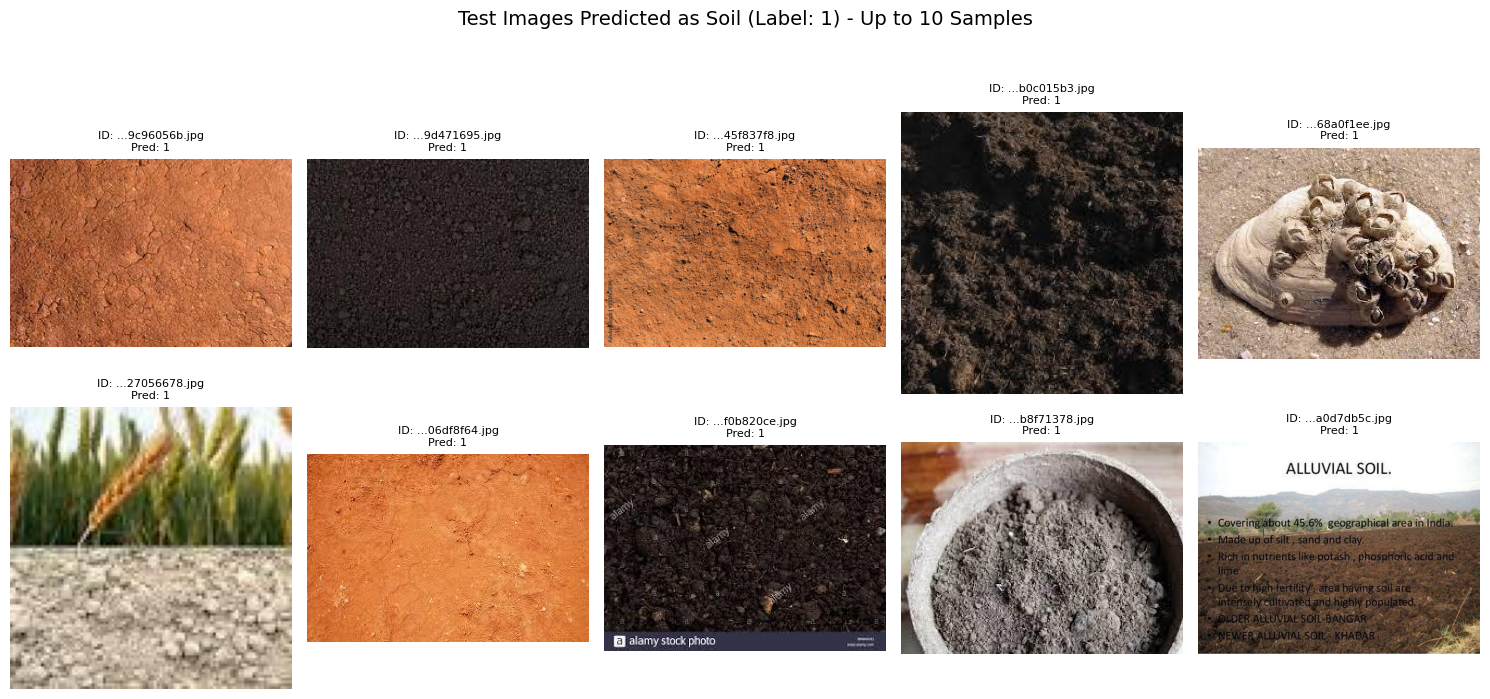

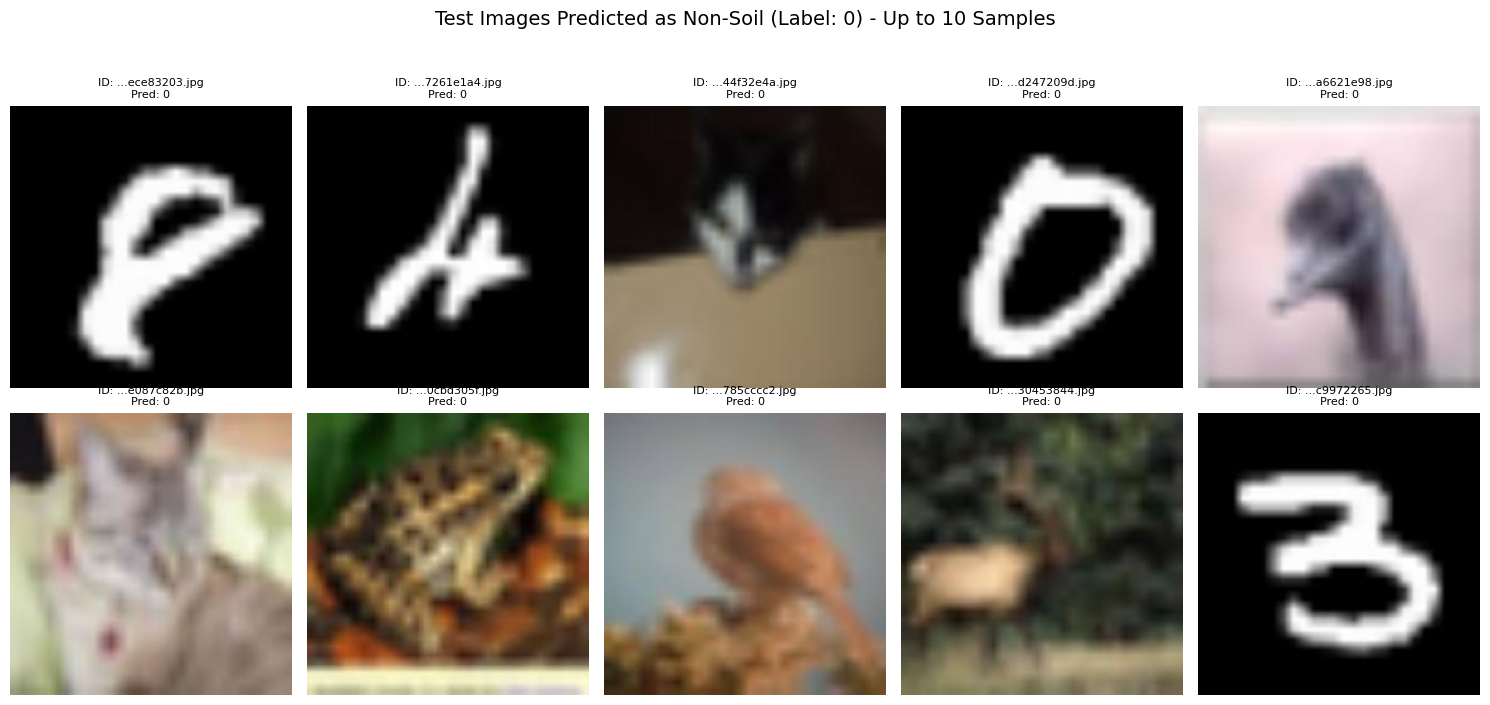


--- Script fully finished ---


In [10]:
# --- 10. Display Sample Predictions from the Test Set ---
# This section is for visual verification and demonstration purposes.
# It shows a few images predicted as "Soil" and "Non-Soil".

MAX_IMAGES_TO_DISPLAY_PER_CLASS = 10 # Show up to 10 images per class
IMAGES_PER_ROW = 5

print("\nStep 10: Displaying sample predictions...")

# Function to plot sample images
def plot_sample_images(image_ids_to_plot, predicted_label_value, title_prefix):
    if not image_ids_to_plot.empty:
        num_images = len(image_ids_to_plot)
        num_rows = (num_images + IMAGES_PER_ROW - 1) // IMAGES_PER_ROW
        
        plt.figure(figsize=(15, num_rows * 3.5)) # Adjust figure size as needed
        plt.suptitle(f"{title_prefix} (Label: {predicted_label_value}) - Up to {num_images} Samples", fontsize=14, y=1.02 if num_rows > 1 else 1.05)
        
        for i, img_id in enumerate(image_ids_to_plot):
            plt.subplot(num_rows, IMAGES_PER_ROW, i + 1)
            img_path = os.path.join(TEST_IMAGE_DIR, img_id)
            try:
                if os.path.exists(img_path):
                    img = Image.open(img_path).convert("RGB")
                    plt.imshow(img)
                    plt.title(f"ID: ...{img_id[-12:]}\nPred: {predicted_label_value}", fontsize=8) # Show last 12 chars of ID
                else:
                    plt.title(f"Image Missing\nID: ...{img_id[-12:]}", fontsize=8)
            except Exception as e:
                # Handle cases where image might be corrupted even if path exists
                plt.title(f"Error Loading\nID: ...{img_id[-12:]}", fontsize=8)
            plt.axis('off') # Hide axes
        plt.tight_layout(rect=[0, 0, 1, 0.98 if num_rows > 1 else 0.95]) # Adjust layout to make space for suptitle
        plt.show()
    else:
        print(f"  No images found with predicted label {predicted_label_value} to display.")

# Get samples predicted as "Soil" (Label 1)
predicted_soil_df = submission_df[submission_df['label'] == 1]
sample_soil_ids = predicted_soil_df['image_id'].sample(
    n=min(MAX_IMAGES_TO_DISPLAY_PER_CLASS, len(predicted_soil_df)), 
    random_state=42 # For reproducible samples
) if not predicted_soil_df.empty else pd.Series(dtype=str)
plot_sample_images(sample_soil_ids, 1, "Test Images Predicted as Soil")

# Get samples predicted as "Non-Soil" (Label 0)
predicted_non_soil_df = submission_df[submission_df['label'] == 0]
sample_non_soil_ids = predicted_non_soil_df['image_id'].sample(
    n=min(MAX_IMAGES_TO_DISPLAY_PER_CLASS, len(predicted_non_soil_df)), 
    random_state=42 # For reproducible samples
) if not predicted_non_soil_df.empty else pd.Series(dtype=str)
plot_sample_images(sample_non_soil_ids, 0, "Test Images Predicted as Non-Soil")

print("\n--- Script fully finished ---")